In [14]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('/Users/ff/dev/MSc/CX_Path_Integration')
os.chdir('/Users/ff/dev/MSc/CX_Path_Integration/notebooks')

In [56]:
from brian2 import *
from brian2tools import *
from brian2modelfitting import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter

import cx_spiking.plotting
import cx_spiking.inputs

In [16]:
# Constants
N_TL2 = 16
N_CL1 = 16
N_TB1 = 8
N_TN2 = 2

In [17]:
route_file = 'data/route.npz'
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=T_outbound, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings, digitized = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from data/route.npz
data/route.npz exists - not overwriting it


In [18]:
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, log, cpu4_snapshot = trials.run_trial(logging=True,
                                            T_outbound=T_outbound,
                                            T_inbound=0,
                                            noise=noise,
                                            cx=cx,
                                            route=(h[:T_outbound], v[:T_outbound]))

In [57]:
start_scope()
#defaultclock.dt = 0.05*ms

time_step = 20 # ms

recorded_spike_rates = 90 # Hz
ratio = recorded_spike_rates / (time_step * 1./1000)
print(f'ratio {ratio} - dt {defaultclock.dt}')

ratio 4500.0 - dt 5e-05


In [58]:
TL2_stimulus = TimedArray(100*log.tl2.T*Hz, dt=1.*time_step*ms)
P_TL2 = PoissonGroup(N_TL2, rates='TL2_stimulus(t,i)')
SPM_TL2_IDEAL = SpikeMonitor(P_TL2)

AttributeError: 'function' object has no attribute 'tl2'

In [45]:
%%time
run(1500*time_step*ms)

WARNING    "i" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


CPU times: user 18.1 s, sys: 381 ms, total: 18.5 s
Wall time: 24.7 s


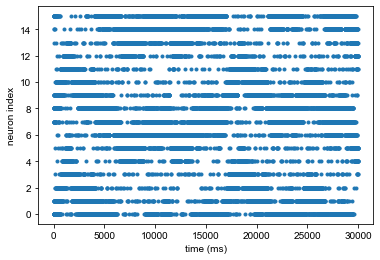

In [46]:
brian_plot(SPM_TL2_IDEAL)

In [47]:
TL2_IDEAL_spikes = cx_spiking.inputs.get_spikes_rates(SPM_TL2_IDEAL, N_TL2, T_outbound, time_step)

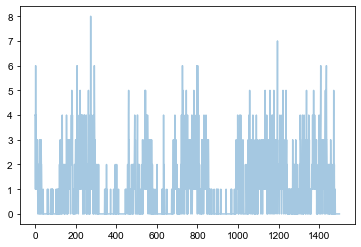

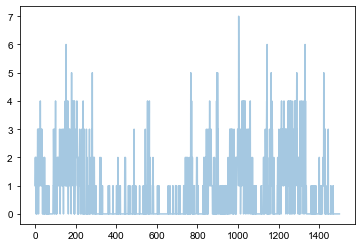

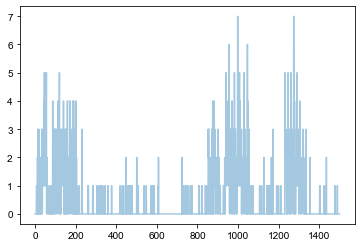

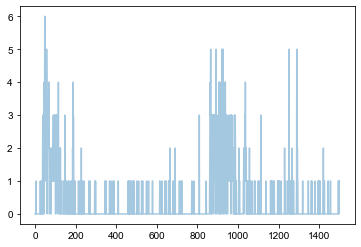

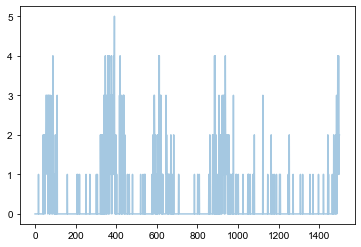

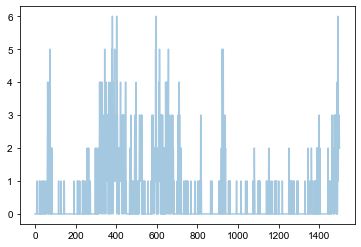

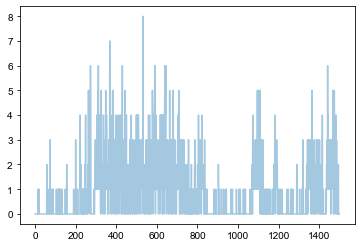

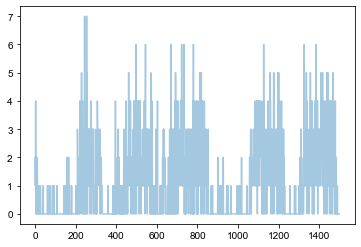

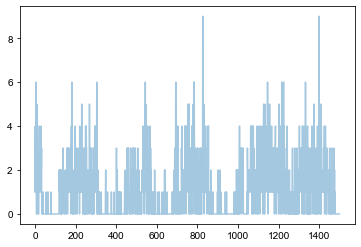

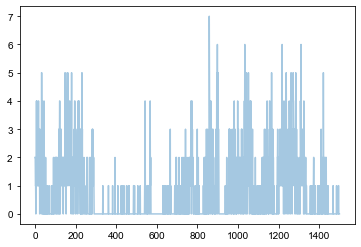

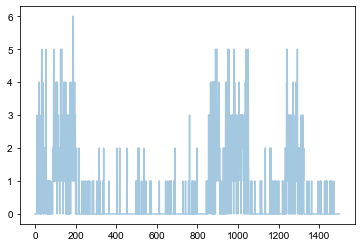

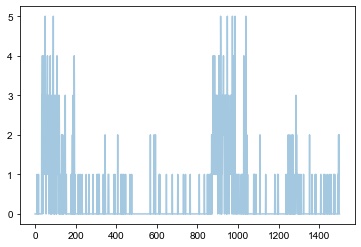

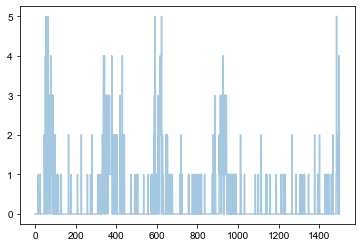

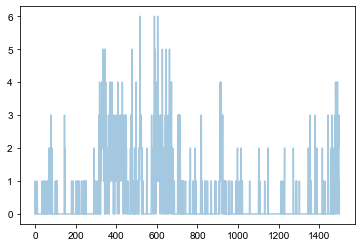

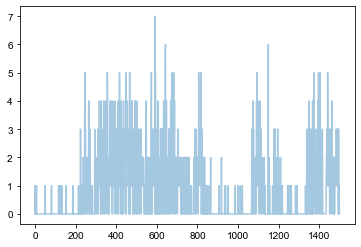

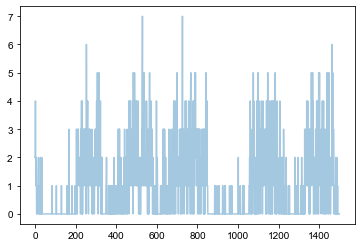

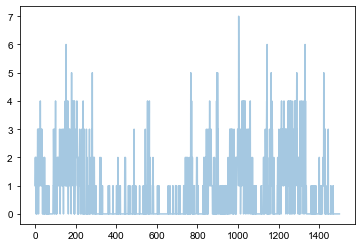

In [48]:
for n in range(N_TL2):
    plt.plot(TL2_IDEAL_spikes[n,:], alpha=0.4)
    plt.show()
plt.show()
plt.plot(TL2_IDEAL_spikes[1,:], alpha=0.4)
plt.show()

In [49]:
spikes_t = SPM_TL2_IDEAL.t/ms
spikes_i = SPM_TL2_IDEAL.i

spikes_out = np.zeros((N_TL2, T_outbound))
bins = np.arange(0, (T_outbound+1)*time_step, time_step)

[5.6000e+00 1.7500e+00 5.5000e+00 5.8500e+00 5.5000e-01 2.3000e+00
 7.7500e+00 1.7450e+01 1.5500e+01 4.1500e+00 2.0500e+00 4.0000e-01
 4.7500e+00 5.5000e-01 4.8500e+00 1.9600e+01 3.9000e+00 4.5000e-01
 5.7000e+00 1.2250e+01 4.4000e+00 9.6000e+00 4.2000e+00 1.4000e+00
 1.0950e+01 6.9000e+00 6.0000e-01 4.2000e+00 2.1300e+01 2.5250e+01
 4.7000e+00 7.5000e-01 1.0600e+01 2.1400e+01 2.1350e+01 4.8150e+01
 9.4500e+00 1.0550e+01 2.1000e+00 2.7900e+01 5.8000e+00 3.0900e+01
 1.1500e+01 1.0200e+01 6.3500e+00 8.4500e+00 8.5000e-01 6.9500e+00
 3.1450e+01 7.0000e-01 4.5000e-01 1.7450e+01 1.9250e+01 7.0000e-01
 1.0000e-01 5.2500e+00 4.8000e+00 7.0500e+01 1.3950e+01 4.1500e+00
 5.8000e+00 5.3500e+00 2.4050e+01 1.7000e+00 1.7350e+01 1.2795e+02
 4.3870e+02 7.9650e+01 2.3215e+02 5.0350e+01 7.3800e+01 3.4200e+01
 3.5250e+01 3.5185e+02 9.3250e+01 2.1150e+01 4.9850e+01 7.5500e+01
 7.4850e+01 2.4500e+00 8.0500e+00 1.6400e+01 2.7550e+01 2.6000e+01
 3.0000e-01 4.2500e+00 3.8050e+01 1.6850e+01 1.7750e+01 5.0500

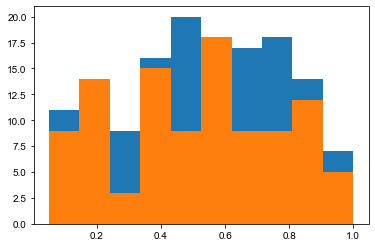

In [53]:
for i in range(2):
    spikes = spikes_t[spikes_i == i]
    spikes_count = np.diff(spikes)
    print(spikes_count[0:100])
    plt.hist(spikes_count[spikes_count<1])